## 1) Carregando o Dataset

In [ ]:
from pathlib import Path
import pandas as pd

# A função pd.read_csv() lê o arquivo e o carrega em um DataFrame do pandas.
DATA_PATH = Path.cwd().joinpath(Path("Exercicio01/dataset/data_0460_5832.csv"))
df = pd.read_csv(DATA_PATH)

# O comando .head() mostra as 5 primeiras linhas do DataFrame.
print("Primeiras 5 linhas do dataset:")
print(df.head())

# O comando .info() mostra um resumo técnico, incluindo os tipos de cada coluna.
print('\nInformações do DataFrame:')
df.info()

Primeiras 5 linhas do dataset:
      Sex  Age  Height  Weight  Shoe number
0  Female   53     154      59           36
1    Male   23     170      56           40
2  Female   23     167      63           37
3    Male   21     178      78           40
4  Female   25     153      58           36

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sex          257 non-null    object
 1   Age          257 non-null    int64 
 2   Height       257 non-null    int64 
 3   Weight       257 non-null    int64 
 4   Shoe number  257 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.2+ KB


## 2) Tratamento dos dados

Antes de treinar nosso modelo, precisamos preparar os dados. Isso envolve:

1.  **Lidar com variáveis categóricas**: A coluna `Sex` é categórica ('Male'/'Female'). Os modelos de regressão linear requerem entradas numéricas. Usaremos uma técnica chamada *one-hot encoding* para converter essa coluna em colunas numéricas (0s e 1s).
2.  **Definir Features (X) e Target (y)**: Separaremos nosso conjunto de dados em:
    * `X`: a matriz de features (as variáveis que usaremos para fazer a previsão).
    * `y`: o vetor alvo (a variável que queremos prever, neste caso, `Weight`).

In [3]:
import numpy as np

# Copiar o df original para não sobrescrever
df_encoded = df.copy()

# Identificar colunas categóricas que só têm dois valores
for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
    valores = df_encoded[col].dropna().unique()
    if len(valores) == 2:
        # mapear automaticamente para 0/1
        mapping = {valores[0]: 0, valores[1]: 1}
        df_encoded[col] = df_encoded[col].map(mapping)
        print(f"Coluna {col} mapeada para {mapping}")
    else:
        df_encoded.drop(columns=[col], inplace=True)
# remove colunas constantes
num_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if df_encoded[c].nunique(dropna=True) > 1]


Coluna Sex mapeada para {'Female': 0, 'Male': 1}


In [7]:
# === Imports ===
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt

## 3) Treino

In [8]:
# === Treino: LogReg em PyTorch (BGD, full-batch) com histórico de loss ===
def fit_logreg_bgd_with_history(X_np, y_np, *, lr=5e-2, epochs=1500, seed=0):
    """
    X_np: array (N, d)
    y_np: array (N,) binário {0,1}
    Retorna: dict com model, scaler, history (loss por época)
    """
    torch.manual_seed(seed)
    X_np = np.asarray(X_np, dtype=float)
    y_np = np.asarray(y_np, dtype=int)

    # 1) padroniza X (igual fazemos com scikit-learn em regressões)
    scaler = StandardScaler().fit(X_np)
    Xz = scaler.transform(X_np)

    # 2) tensores
    X = torch.tensor(Xz, dtype=torch.float32)
    y = torch.tensor(y_np.reshape(-1, 1), dtype=torch.float32)

    # 3) modelo e otimizador
    model = nn.Linear(X.shape[1], 1)                 # ŷ = w0 + w1 x1 + ...
    crit  = nn.BCEWithLogitsLoss()                   # BCE direto nos logits
    opt   = torch.optim.SGD(model.parameters(), lr=lr)

    history = []
    for ep in range(1, epochs + 1):
        opt.zero_grad()
        logits = model(X)
        loss   = crit(logits, y)
        loss.backward()
        opt.step()

        # guarda loss por época (float)
        history.append(float(loss.detach()))

    return {
        "model": model,
        "scaler": scaler,
        "history": history,
    }

## 3) Análises

In [13]:
# === Avaliação + plots para split específico ===
def evaluate_and_plot(model, scaler, X_np, y_np, title_prefix="TESTE"):
    """
    Imprime métricas e plota: matriz de confusão + ROC.
    """
    X_np = np.asarray(X_np, dtype=float)
    y_np = np.asarray(y_np, dtype=int)

    Xz  = scaler.transform(X_np)
    Xt  = torch.tensor(Xz, dtype=torch.float32)

    with torch.no_grad():
        logits = model(Xt).squeeze(1).cpu().numpy()
        prob   = 1 / (1 + np.exp(-logits))           # sigmoid
    pred = (prob >= 0.5).astype(int)

    # ----- métricas clássicas -----
    acc  = accuracy_score(y_np, pred)
    prec = precision_score(y_np, pred, zero_division=0)
    rec  = recall_score(y_np, pred, zero_division=0)
    f1   = f1_score(y_np, pred, zero_division=0)
    auc_ = roc_auc_score(y_np, prob)

    print(f"\n[{title_prefix}]")
    print(f"Acc: {acc:.4f}")
    print(f"Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    print(f"ROC-AUC: {auc_:.4f}")

    # ----- GRÁFICOS -----
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # (a) matriz de confusão
    cm = confusion_matrix(y_np, pred)
    im = ax[0].imshow(cm, cmap="Blues")
    ax[0].set_title(f"Matriz de confusão ({title_prefix})")
    ax[0].set_xlabel("Predito"); ax[0].set_ylabel("Verdadeiro")
    for (i, j), v in np.ndenumerate(cm):
        ax[0].text(j, i, str(v), ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

    # (b) curva ROC manual (compatível com qualquer versão do sklearn)
    fpr, tpr, _ = roc_curve(y_np, prob)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color="blue", label=f"AUC={roc_auc:.3f}")
    ax[1].plot([0, 1], [0, 1], "--", color="k", lw=1)
    ax[1].set_xlim(0, 1); ax[1].set_ylim(0, 1)
    ax[1].set_xlabel("FPR"); ax[1].set_ylabel("TPR")
    ax[1].set_title(f"Curva ROC ({title_prefix})")
    ax[1].legend()
    ax[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # retorna para quem quiser registrar
    return {
        "acc": acc, "prec": prec, "rec": rec, "f1": f1, "roc_auc": auc_
    }

In [14]:
# === Plot da loss por época ===
def plot_loss_history(history, title="BGD: curva de loss (treino)"):
    plt.figure(figsize=(7, 4))
    plt.plot(history, color="tab:blue")
    plt.title(title)
    plt.xlabel("Época")
    plt.ylabel("Loss (BCE)")
    plt.grid(alpha=0.3)
    plt.show()

In [15]:
# ——————————————————————————————————————————————
# (Opcional) Exemplo de split rápido se ainda não tiver:
# Supondo df_encoded com FEATS (lista de colunas de entrada) e TARGET ("Sex" ou similar)
try:
    X_tr, y_tr, X_te, y_te  # checa se já existem
except NameError:
    from sklearn.model_selection import train_test_split
    FEATS  = [c for c in df_encoded.columns if c != "sex"]  # ajuste aqui suas colunas
    TARGET = "sex"                                          # ajuste aqui o alvo binário
    X      = df_encoded[FEATS].to_numpy(float)
    y      = df_encoded[TARGET].to_numpy(int)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
# ——————————————————————————————————————————————

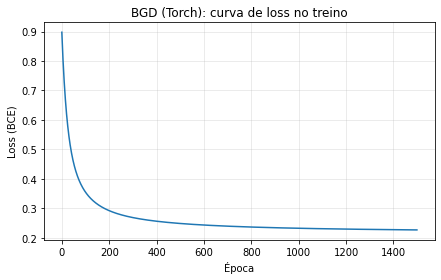


[TREINO]
Acc: 0.9115
Prec: 0.9254 | Rec: 0.9466 | F1: 0.9358
ROC-AUC: 0.9612


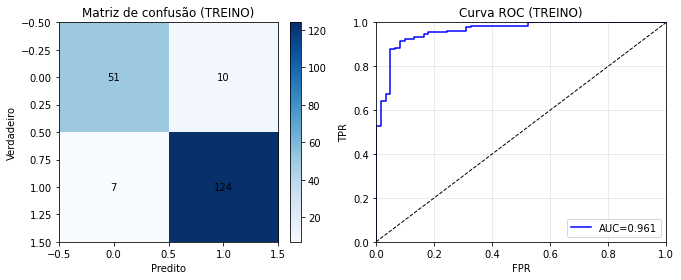


[TESTE]
Acc: 0.8615
Prec: 0.9500 | Rec: 0.8444 | F1: 0.8941
ROC-AUC: 0.9311


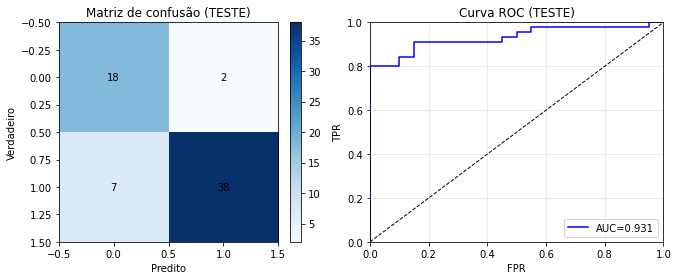

In [16]:
# === Treino (BGD) ===
bgd = fit_logreg_bgd_with_history(X_tr, y_tr, lr=5e-2, epochs=1500, seed=0)

# Curva de aprendizado (loss)
plot_loss_history(bgd["history"], title="BGD (Torch): curva de loss no treino")

# === Avaliação com gráficos ===
_ = evaluate_and_plot(bgd["model"], bgd["scaler"], X_tr, y_tr, title_prefix="TREINO")
_ = evaluate_and_plot(bgd["model"], bgd["scaler"], X_te, y_te, title_prefix="TESTE")